### Atmospheric drag
Another non gravitational force that requires precise shape calculations is the atmospheric drag. 
Especially when a spacecraft has a time-changing attitude, which can be related to pointing operations or to moveable appendages (e.g., solar panels, antennas) one has to precisely compute the cross section in the velocity direction over time. 

`pyRTX` can handle precise shape calculations. 
This notebook will show how to calculate the cross section, and how to compute the atmospheric drag from it. 

In [1]:
import spiceypy as sp
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import trimesh as tm
from tqdm.notebook import tqdm

from pyRTX.classes.Spacecraft import Spacecraft
from pyRTX.classes.Drag import Drag
from pyRTX.classes.LookUpTable import LookUpTable
from pyRTX.classes.Precompute import Precompute
from pyRTX.core.analysis_utils import epochRange2
from pyRTX.visual.utils import plot_mesh
from pyRTX.core.analysis_utils import get_spacecraft_area
from pyRTX.classes.PixelPlane import PixelPlane
from pyRTX.classes.RayTracer  import RayTracer

import warnings
warnings.filterwarnings('ignore')

METAKR      =  '../example_data/LRO/metakernel_lro.tm'     # metakernel
obj_path    =  '../example_data/LRO/'				       # folder with shape .obj files


# Load the metakernel containing references to the necessary SPICE frames
sp.furnsh(METAKR)

Let's define the spacecraft. In this example we will a simple shape and pretend it's LRO. We do this for simplicity since we already have the SPICE kernels for it. We use a simple shape and not the full LRO shape (with moveable appendages) to simplify this example. A full example on how to compute drag on a time-varying shape is provided in the `examples` folder in the `lro_drag.py` example. 

Clearly the Moon is an airless body. Again, for simplicity we will assume this is not true and define an atmosphere for the Moon.


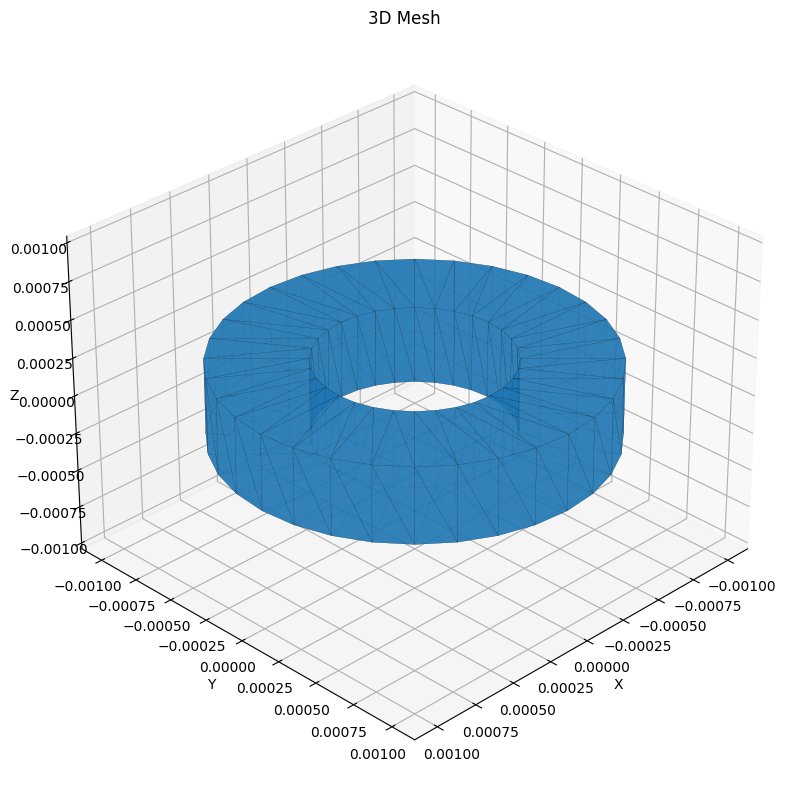

In [2]:
# Define the spacecraft 
mesh = tm.creation.annulus(0.5,1,height = 0.5)
# mesh = tm.creation.icosphere(5, 1)

# Note this has moving frames, so the shape is time-variable
sc_mass = 1000
sc = Spacecraft( 
            name = 'LRO',
            base_frame = 'LRO_SC_BUS', # Name of the spacecraft body-fixed frame
            mass = sc_mass, 
            units = 'm',
            spacecraft_model = { 
       
            
            'Bus': { 
                'file' : mesh,  # Note that you can also input directly a mesh (it must be trimesh.Trimesh object)
                'frame_type': 'UD', # type of frame (can be 'Spice' or 'UD'= User Defined)
                'UD_rotation' : tm.transformations.identity_matrix(), # If UD is chosen, the rotation matrix between the element and the base frame must be defined
                'frame_name': 'SC Bus', # Name of the frame
                'center': [0.0,0.0,0.0], # Origin of the component
                'diffuse': 0.3, # Diffuse reflect. coefficient
                'specular': 0.3, # Specular reflect. coefficient
                
                
            },
            },


                )

# Note: axes are in km
plot_mesh(mesh);

### Compute the cross-section LUT
First of all we'll need to compute a lookup table for the cross-section. 


In [3]:
# Let's define a grid for the calculation
# Since the "spacecraft" is axially symmetric we need 
# only a coarse grid in right ascension
grid_res_ra = 180 * np.pi/180 # radians
grid_res_dec = 5 * np.pi/180 # radians

RA = np.linspace(0, 2*np.pi, int(2*np.pi/grid_res_ra) + 1)
DEC = np.linspace(-np.pi/2, np.pi/2, int(np.pi/grid_res_dec)+1)


# Define a function for computing the area. 
# The same function is provided in pyRTX.core.analysis_utils.get_spacecraft_area
# however that prescribes the size of the pixel plane and its density, so the user 
# has to make sure it works for their case. 
# Future versions of pyRTX will implement an automatic definition of the pixel plane, based 
# on the spacecraft shape and dimensions. 
pp = PixelPlane( 
        spacecraft = sc, 
        mode = 'Fixed', 
        distance = 0.1, # km
        width = 2*1e-3, # km
        height = 2*1e-3, # km
        lon = 0, 
        lat = 0, 
        ray_spacing = 0.001e-3, #km
        units = 'km', 
)

total_iters = len(RA)*len(DEC)
pbar = tqdm(total=total_iters, desc='RA×DEC total')

crossection = np.zeros((len(RA), len(DEC)))
for ira, ra in enumerate(RA):
    for ide, dec in enumerate(DEC):
        area = get_spacecraft_area(sc, pp, ra=ra, dec=dec)  #km2
        crossection[ira, ide] = area
        pbar.update(1)


RA×DEC total:   0%|          | 0/111 [00:00<?, ?it/s]

In [4]:
# Let's save the LUT. This way we can just re-load it instead of recomputing it
axes = []
dims = []

axes.append(RA)
axes.append(DEC)
dims.append('ra')
dims.append('dec')
dims.append('value')


attrs = {
    'base_frame' : 'LRO_SC_BUS', 
    'units' : 'm*2',
    'ref_epoch' : 'None', 
    'dims' : ",".join(dims), 
    # These are needed when there are moving parts. 
    # It will be discussed in a later example
    'eul_set' : '1,2,3',  
    'moving_frames' : '', 
}


crossection_lut = crossection[..., np.newaxis] # This needs to be 3D

shape = tuple([len(r) for r in axes] + [1] )
coords = {dims[i]: vals for i, vals in enumerate(axes)}

LUT = xr.Dataset(data_vars = {'look_up_table' : (dims, crossection_lut)}, 
                 coords = coords, 
                 attrs = attrs)

LUT.to_netcdf('outputs/area_lut.nc', encoding = LUT.encoding.update({'zlib': True, 'complevel': 1}))

### Computing the drag
Now that we have computed the cross-section lookup table we can proceed to compute the atmospheric drag. 
To do so, we need to define an atmospheric model. 

In [5]:
# The atmospheric density is user-defined. pyRTX enables the definition of custom atmospheric models. 
# The used must define a function with the following call sign
# density [kg/m3] = function(height [km], )
# More complex models accounting for spatio-temporal variabilities can be implemented. This can be easily done
# by the user by modifying the function run() of the Drag class. 
# The next version of pyRTX will support by default density functions of the type
# density [kg/m3] = function(height [km], lon [rad], lat [rad], epoch [et sec])

# Simple exponential density model
Moon_radius = 1740
def density(h):
    # NOTE: h is the distance from the center of the body in km
    h -= Moon_radius
    return (1e-6)*np.exp(-h/100)	# kg/m**3


In [6]:
# Define the epochs for computation
from pyRTX.core.analysis_utils import epochRange2


# Define a set of epochs on which we want to perform the computation
ref_epc		= "2010 may 10 09:25:00"
duration    = 5000								
timestep    = 50
epc_et0  = sp.str2et( ref_epc )
epc_et1  = epc_et0 + duration
epochs   = epochRange2(startEpoch = epc_et0, endEpoch = epc_et1, step = timestep)


In [7]:
lut = LookUpTable('outputs/area_lut.nc') 
CD = 2.0 # Spacecraft drag coefficient
accel_frame = 'MOON_ME'

# Precomputation object
prec = Precompute(epochs = epochs,)
prec.precomputeDrag(sc, 'Moon', lut.moving_frames, accel_frame)
prec.dump()

drag = Drag(
                sc,
                lut,
                density,
                CD,
                'Moon',
                precomputation = prec, 
)


# And compute it on a certain time span
accel, velocity = drag.compute(epochs, accel_frame)

Text(0.5, 0, 'Hours')

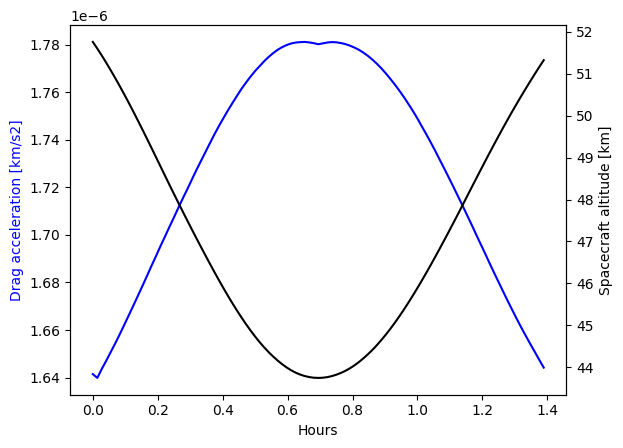

In [8]:
# and to visualize it, let's plot the magnitude of the drag acceleration
# together with the spacecraft height
from pyRTX.utilities import getScPosVel
pos, vel = getScPosVel('LRO','Moon', epochs, 'MOON_ME')


fig, ax = plt.subplots()
plot_epochs = np.array([e - epochs[0] for e in epochs] ) /3600
ax.plot(plot_epochs, np.linalg.norm(accel, axis = 1), color = 'blue')
ax2 = ax.twinx()
ax2.plot(plot_epochs, np.linalg.norm(pos, axis = 1) - Moon_radius, color = 'black')

ax.set_ylabel('Drag acceleration [km/s2]', color = 'blue')
ax2.set_ylabel('Spacecraft altitude [km]')
ax.set_xlabel('Hours')